In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%ls /content/gdrive/My\ Drive/Colab\ Notebooks/Digital\ Image\ Processiing/HW6/*.py
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6')

'/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6/cwSaab.py'
'/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6/main.py'
'/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6/pixelhop.py'
'/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6/saab.py'


In [3]:
# import datasets
from keras.datasets import fashion_mnist

In [4]:
# import base python libraries
import pandas as pd
import numpy as np
from numpy import save
from numpy import load
import matplotlib.pyplot as plt
import warnings, gc
import time

In [5]:
# import ml framework libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import xgboost as xgb

In [6]:
# import sklearn libs
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce
from skimage.util import view_as_windows
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import pickle
#from xgboost import XGBClassifier

In [7]:
# special imports
from pixelhop import Pixelhop

In [8]:
np.random.seed(1)

# Preprocess
N_Train_Reduced = 10000    # 10000
N_Train_Full = 60000       # 50000
N_Test = 10000             # 10000

BS = 2000 # batch size

In [9]:
def shuffle_data(X, y):
    shuffle_idx = np.random.permutation(y.size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

In [10]:
def select_balanced_subset(images, labels, use_num_images):
    '''
    select equal number of images from each classes
    '''
    num_total, H, W, C = images.shape
    num_class = np.unique(labels).size
    num_per_class = int(use_num_images / num_class)

    # Shuffle
    images, labels = shuffle_data(images, labels)

    selected_images = np.zeros((use_num_images, H, W, C))
    selected_labels = np.zeros(use_num_images)

    for i in range(num_class):
        selected_images[i * num_per_class:(i + 1) * num_per_class] = images[labels == i][:num_per_class]
        selected_labels[i * num_per_class:(i + 1) * num_per_class] = np.ones((num_per_class)) * i

    # Shuffle again
    selected_images, selected_labels = shuffle_data(selected_images, selected_labels)
    print(selected_labels)

    return selected_images, selected_labels


In [11]:
def Shrink(X, shrinkArg):
    #---- max pooling----
    pool = shrinkArg['pool']

    ch = X.shape[-1]  # get the number of channels

     # fill in the rest of max pooling
    if (pool > 1):
      X = block_reduce(X, block_size = (1, pool , pool, ch), func = np.max)

    #---- neighborhood construction
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    pad = shrinkArg['pad']
    
    # fill in the rest of neighborhood construction
   
    if pad > 0:
      X = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0, 0)), 'reflect')
    X = view_as_windows(X, (1, win , win , 1 ), (1, stride, stride, 1))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)

    print(X.shape[0], X.shape[1], X.shape[2], -1)
    return  X


In [12]:
# example callback function for how to concate features from different hops
def Concat(X, concatArg):
    return X

In [13]:
def get_feat(p2, X, num_layers=3):
    output = p2.transform_singleHop(X,layer=0)
    if num_layers>1:
        for i in range(num_layers-1):
            output = p2.transform_singleHop(output, layer=i+1)
    return output

In [14]:
warnings.filterwarnings("ignore")
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [15]:
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')[:,:,:,np.newaxis]
x_test = np.asarray(x_test,dtype='float32')[:,:,:,np.newaxis]
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')

# if use only 10000 images train pixelhop
x_train_reduced, y_train_reduced = select_balanced_subset(x_train, y_train, use_num_images=N_Train_Reduced)

x_train /= 255.0
x_test /= 255.0

x_train_reduced /=255.0
#x_test /=255.0

print(" input feature full train dataset shape: %s"%str(x_train.shape))
print(" input feature full test dataset shape: %s"%str(x_test.shape))

print(" input feature reduced train dataset shape: %s"%str(x_train_reduced.shape))
print(" input feature reduced test dataset shape: %s"%str(y_train_reduced.shape))
print(" y_train shape: %s"%str(y_train_reduced))

[3. 1. 5. ... 5. 7. 3.]
 input feature full train dataset shape: (60000, 28, 28, 1)
 input feature full test dataset shape: (10000, 28, 28, 1)
 input feature reduced train dataset shape: (10000, 28, 28, 1)
 input feature reduced test dataset shape: (10000,)
 y_train shape: [3. 1. 5. ... 5. 7. 3.]


In [16]:
# -----------Module 1: set PixelHop parameters-----------
module1_start_time = time.time()

# fill in this part
shrinkArgs = [{'func': Shrink, 'win':5, 'stride': 1, 'pad':2, 'pool': 1},
            {'func': Shrink, 'win':5, 'stride': 1,'pad':0, 'pool': 2 }, 
            {'func': Shrink, 'win':5, 'stride': 1,  'pad':0, 'pool': 2}]
         
          
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'cw': False},
        {'num_AC_kernels':-1, 'needBias':True,   'cw': True}, 
        {'num_AC_kernels':-1, 'needBias':True,   'cw': True}]
   

concatArg = {'func':Concat}

In [17]:
# -----------Module 1: Train PixelHop -----------
# TODO: fill in this part
pixelplus = Pixelhop(depth = 3,
                    TH1 = 0.0005,  #will vary this part
                    TH2 = 0.001,
                    SaabArgs = SaabArgs,
                    shrinkArgs = shrinkArgs, 
                    concatArg = concatArg).fit(x_train_reduced)

print("Module 1 took {0} seconds.".format(time.time() - module1_start_time))

10000 28 28 -1
10000 28 28 -1
=============================================>c/w Saab Train Hop 1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
=============================================>c/w Saab Train Hop 2
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
100

In [18]:
# save  the Pixelhop model                    
#pickle.dump(pixelplus, open('/content/gdrive/My Drive/Colab Notebooks/Digital Image Processiing/HW6/pixelHop_4units.sav', 'wb'))

In [19]:
# --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
# you can get feature "batch wise" and concatenate them if your memory is restricted
# TODO: fill in this part
#train_hop1_feats = pixelplus.transform(x_train)
#train_hop3_feats = get_feat(pixelplus, x_train_reduced)
#test_hop3_feats = get_feat(pixelplus, x_test)

In [20]:
# --------- Module 2: get only Hop 3 feature for both training set and testing set -----------
# you can get feature "batch wise" and concatenate them if your memory is restricted
# TODO: fill in this part

module2_start_time = time.time()

# apply transform to whole 60k train images in batches
op1 = get_feat(pixelplus, x_train[:10000,:,:])
op2 = get_feat(pixelplus, x_train[10000:20000,:,:])
op3 = get_feat(pixelplus, x_train[20000:30000,:,:])
op4 = get_feat(pixelplus, x_train[30000:40000,:,:])
op5 = get_feat(pixelplus, x_train[40000:50000,:,:])
op6 = get_feat(pixelplus, x_train[50000:60000,:,:])

# apply transform to 10k test images
test_hop3_feats = get_feat(pixelplus, x_test)

# get only hop3 features by concatenating the batched transforms
#train_hop3_feats = np.concatenate((op1[3],op2[3],op3[3],op4[3],op5[3], op6[3]))

10000 28 28 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 10 10 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
10000 1 1 -1
100

In [21]:
# get only hop3 features by concatenating the batched transforms
train_hop3_feats = np.concatenate((op1,op2,op3,op4,op5,op6))

In [22]:
print( "Hop3 train features shape: ", train_hop3_feats.shape)
print("Hop3 test features shape: ", test_hop3_feats.shape) 

Hop3 train features shape:  (60000, 1, 1, 78)
Hop3 test features shape:  (10000, 1, 1, 78)


In [23]:
# --------- Module 2: standardization of the Hop features
STD = np.std(train_hop3_feats, axis=0, keepdims=1)
train_hop3_feats = train_hop3_feats/STD
test_hop3_feats = test_hop3_feats/STD

print("Standardized vector shape: ", STD.shape) 
print( "Hop3 train features shape: ", train_hop3_feats.shape)
print("Hop3 test features shape: ", test_hop3_feats.shape) 
print("input feature train shape: %s"%str(y_train.shape)) 

Standardized vector shape:  (1, 1, 1, 78)
Hop3 train features shape:  (60000, 1, 1, 78)
Hop3 test features shape:  (10000, 1, 1, 78)
input feature train shape: (60000,)


In [24]:
train_hop3_feats = np.squeeze(train_hop3_feats)
test_hop3_feats = np.squeeze(test_hop3_feats)

print( "Hop3 train features shape: ", train_hop3_feats.shape)
print("Hop3 test features shape: ", test_hop3_feats.shape) 

print("Module 2 took {0} seconds.".format(time.time() - module2_start_time))

Hop3 train features shape:  (60000, 78)
Hop3 test features shape:  (10000, 78)
Module 2 took 652.5873398780823 seconds.


In [25]:
 #---------- Module 3: Train XGBoost classifier on hop3 feature ---------

module3_start_time = time.time()

tr_acc = []
te_acc = []

# multiclass classification, so use multi:softprob
clf = xgb.XGBClassifier(n_jobs=-1,
                     objective='multi:softprob',
                    # tree_method='gpu_hist', gpu_id=None,
                    max_depth=3,n_estimators=100,
                    min_child_weight=5,gamma=1,
                    subsample=0.8,learning_rate=1.0,
                    nthread=8,colsample_bytree=1.0)


In [26]:
# TODO: fill in the rest and report accuracy
clf.fit(train_hop3_feats, y_train)

print("Module 3 took {0} seconds.".format(time.time() - module3_start_time))

Module 3 took 226.93743324279785 seconds.


In [27]:
y_train_pred = clf.predict(train_hop3_feats)
train_predictions = [round(value) for value in y_train_pred]
# evaluate accuracy for test 
tr_acc = accuracy_score(y_train, train_predictions)
print("Train Accuracy: %.2f%%" % (tr_acc * 100.0))

Train Accuracy: 95.34%


In [28]:
y_test_pred = clf.predict(test_hop3_feats)
test_predictions = [round(value) for value in y_test_pred]
# evaluate accuracy for test 
te_acc = accuracy_score(y_test, test_predictions)
print("Test Accuracy: %.2f%%" % (te_acc * 100.0))

Test Accuracy: 86.06%


[[810   0  25  39   4   1 108   0  13   0]
 [  1 967   2  20   5   0   3   0   2   0]
 [ 17   0 771  12 100   0  94   0   6   0]
 [ 18  10  10 868  42   1  46   0   5   0]
 [  4   1  82  35 783   0  88   0   7   0]
 [  1   0   0   1   0 944   0  36   3  15]
 [145   1 101  35 100   0 611   0   7   0]
 [  0   0   0   0   0  28   0 932   2  38]
 [  6   0   5   8   4   2   6   0 967   2]
 [  0   0   0   0   0   6   1  40   0 953]]


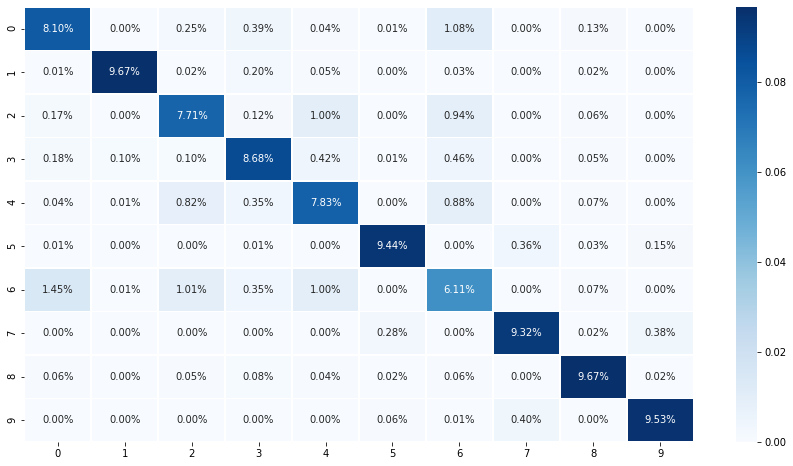

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_test_pred)
print(cf_matrix)
  
# heatmap here and see percentages of data represented in each quadrant
plt.subplots(figsize =(15,8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%',cmap='Blues',linewidths=.6, xticklabels='auto')
